# Homework 17 - Abalone Classification

**1.	What is inductive reasoning? Deductive reasoning? Give an example of each, different from the examples given in class.** 

Inductive reasoning is taking a specific observation to make a more generalized conclusion. You are using that observation to develop a theory. For example, the logic of "I know several people with Omicron right now (observation). Omicron is highly contagious (my theory)." would be inductive.

Deductive reasoning is using a more general observation to make a specific conclusion. In other words, you already have the theory to test against. For example, the logic "Viruses are contagious (theory). Omicron is a virus. Omicron must be contagious (hypothesis to test)" would be deductive. 

**Using ONE of the following sources, complete the questions for only that source.** 
- Credit approval: https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29
- Cardiac Arrhythmia: https://archive.ics.uci.edu/ml/datasets/Arrhythmia 
- Abalone age: https://archive.ics.uci.edu/ml/datasets/Abalone - this one is a bit harder since it’s not binary like the others, but if you really want to master these concepts, you should pick this one. Use RMSE as a performance metric if you do this as regression. You should target a value of under 3.  

*Note: at least one of your models should have the most relevant performance metric above .90 . All performance metrics should be above .75 . You will partially be graded on model performance.*


**2.	Preprocess your dataset. Indicate which steps worked and which didn’t. Include your thoughts on why certain steps worked and certain steps didn’t.** 

*Steps that did not work:*
- Handling and cleaning up missing data did not apply to this data set, as there were not any null values (see below).
- Aggressive outlier removal (see further detail below)**

*Steps that did work:*
- Converting the only categorical column (sex) to numeric, using one-hot encoding
- Basic feature engineering by converting the "rings" column to "age". I did this by adding 1.5 to all values (this was referenced as an acceptable estimate in the original data source).  
- Search and removal of outliers to lower the amount of bias in my model.** 
- Standardization of data, which I completed after splitting into training and testing sets
- Feature selection in an attempt to eliminate multicollinearity***


** I computed all three models (decision tree, random forest, and XGBoost) originally, with an aggressive approach to outlier removal. I created a function to systematically replace all values that fell into (lb = Q1 - 1.5*IQR; or ub = Q3 + 1.5*IQR) with nulls. I then removed any rows with any null values to have a "complete" data set. Doing so, eliminated close to 10% of the data set. My original intent was to drastically decrease the bias in the sample to create more robust results. I achieved RMSE values below 2.0, with 1.57 being my best (XGBoost). However, I started to worry that my model was overfitting and/or that it would not be generalizable to future data sets. To resolve this, I re-did the exercise with a much more conservative approach to my outlier removal. I ended up removing only 6 rows of data in total. Resultantly, my RMSE values were higher. However, they were still fairly good and I was able to feel more confident that my model was not overfitting and that it would be more generalizable to future data sets.

*** More trial and error! I ran all three models (decision tree, random forest, and XGBoost) without any feature selection at first. After doing so, I revisited my pre-processing steps to search for multicollinearity, which is something I should have done earlier to help avoid bias. The RMSE did lower, but only slightly. I decided to keep this version of my pre-processed data since there is inherently less bias.

Full code for the above preprocessing steps is outlined below.

In [1]:
# Load in basic libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the file
abalone = pd.read_csv('abalone.csv')

# Original data length
print(str(len(abalone.index))+' rows')

# View file
abalone.sample(5)

4177 rows


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
3304,F,0.570,0.435,0.140,0.8085,0.3235,0.1830,0.220,16
2337,M,0.560,0.455,0.165,0.8600,0.4015,0.1695,0.245,11
977,F,0.535,0.400,0.135,0.8215,0.3935,0.1960,0.205,8
3979,M,0.495,0.375,0.115,0.6245,0.2820,0.1430,0.155,6
481,M,0.575,0.400,0.155,0.9325,0.3605,0.2445,0.300,17


In [8]:
# Confirm how many null values there are
abalone.isnull().sum()

        # No missing data to handle

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [11]:
# Check data types
abalone.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object

Only one character variable (sex) and the rest are numeric. In future steps, we will process the sex variable.

In [2]:
# View the unique sex categories
abalone['Sex'].unique()

array(['M', 'F', 'I'], dtype=object)

In [3]:
# Encode the sex variables into binary
sex_enc = pd.get_dummies(abalone['Sex'])
sex_enc.head()

,F,I,M
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0


In [4]:
# Concatenate the data frames and confirm that the encoding seems correct
abalone_df = pd.concat([abalone, sex_enc], axis=1)
abalone_df.head() # everything looks good

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,F,I,M
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


In [5]:
# Drop the original sex variable from data frame
abalone_df = abalone_df.drop('Sex', axis=1)

Now that we have completed our one-hot encoding, we can check the general distributions of all our variables

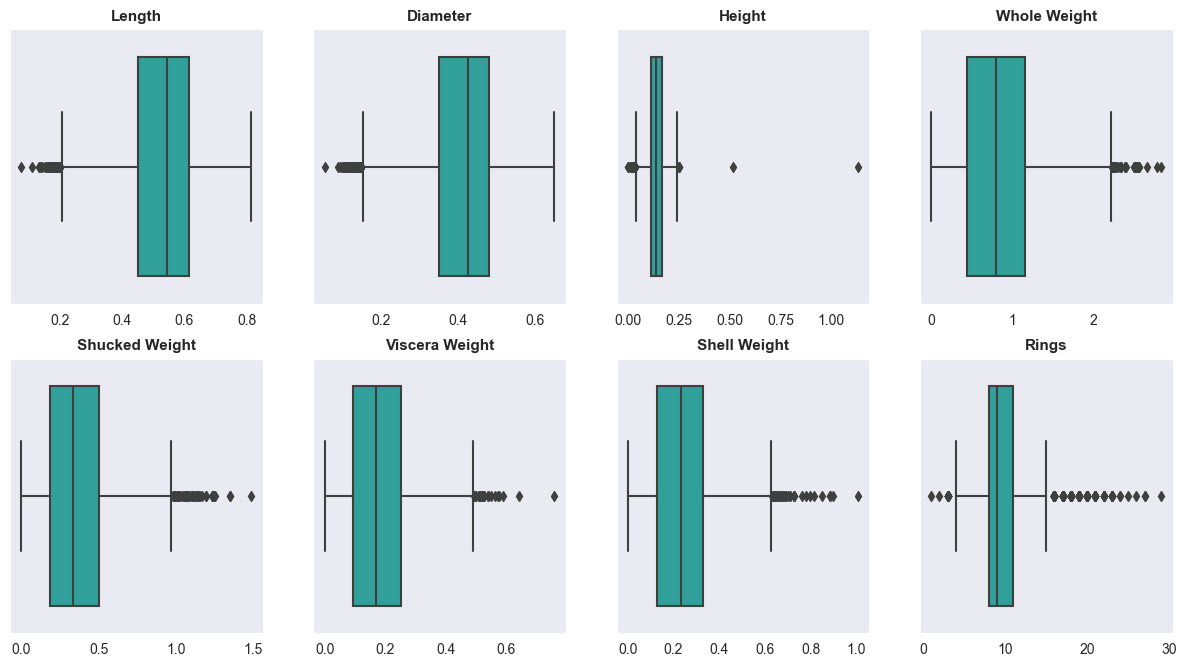

In [38]:
# Check the distribution of each variable (other than sex)

# Set up subplots
fig, axes = plt.subplots(2,4)

# Set up the box plots in each subplot
sns.boxplot(x='Length', color='lightseagreen', data=abalone_df, ax=axes[0,0])
sns.boxplot(x='Diameter', color='lightseagreen', data=abalone_df, ax=axes[0,1])
sns.boxplot(x='Height', color='lightseagreen', data=abalone_df, ax=axes[0,2])
sns.boxplot(x='Whole weight', color='lightseagreen', data=abalone_df, ax=axes[0,3])
sns.boxplot(x='Shucked weight', color='lightseagreen', data=abalone_df, ax=axes[1,0])
sns.boxplot(x='Viscera weight', color='lightseagreen', data=abalone_df, ax=axes[1,1])
sns.boxplot(x='Shell weight', color='lightseagreen', data=abalone_df, ax=axes[1,2])
sns.boxplot(x='Rings', color='lightseagreen', data=abalone_df, ax=axes[1,3])

# Format the axes
axes[0,0].set_title('Length', size=11, weight='bold')
axes[0,0].set_xlabel('')

axes[0,1].set_title('Diameter', size=11, weight='bold')
axes[0,1].set_xlabel('')

axes[0,2].set_title('Height', size=11, weight='bold')
axes[0,2].set_xlabel('')

axes[0,3].set_title('Whole Weight', size=11, weight='bold')
axes[0,3].set_xlabel('')

axes[1,0].set_title('Shucked Weight', size=11, weight='bold')
axes[1,0].set_xlabel('')

axes[1,1].set_title('Viscera Weight', size=11, weight='bold')
axes[1,1].set_xlabel('')

axes[1,2].set_title('Shell Weight', size=11, weight='bold')
axes[1,2].set_xlabel('')

axes[1,3].set_title('Rings', size=11, weight='bold')
axes[1,3].set_xlabel('')

sns.set_style('dark')

# Make plots larger
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':100})

# Show plot
plt.show()

The variables in the bottom row all display a right-skewed distributions. Length and diameter are both left-skewed, while height and "whole weight" are both right-skewed. However, logistic regression does not assume linearity, nor does it require normality so the skewness is not too concerning. However, the plots show that every variable contains outliers. These outliers can bias our model and hinder model performance. 

At the same time, we do not need to be overlly zealous with our outlier removal, as many of the outliers are fairly clustered together and can even be informative. Plus, our decision tree-based models are more robust against outliers than some other models. 

We will handle select outliers in the code below.

First, I methodically sorted by each variable (both descending and then ascending). This allowed me to manually scan for larger leaps in the data.

In [6]:
# Remove heights greater than 0.250 (2051 & 1417)
# Length less than 0.075 (236)
# Shucked weight > 1.488 (1209)
# Viscera weight > 0.76 (1763)
# Shell weight > 1.005 (163)

abalone_df.sort_values('Height', ascending=False)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,F,I,M
2051,0.455,0.355,1.130,0.5940,0.3320,0.1160,0.1335,8,1,0,0
1417,0.705,0.565,0.515,2.2100,1.1075,0.4865,0.5120,10,0,0,1
1763,0.775,0.630,0.250,2.7795,1.3485,0.7600,0.5780,12,0,0,1
1428,0.815,0.650,0.250,2.2550,0.8905,0.4200,0.7975,14,1,0,0
2179,0.595,0.470,0.250,1.2830,0.4620,0.2475,0.4450,14,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1174,0.635,0.495,0.015,1.1565,0.5115,0.3080,0.2885,9,1,0,0
2169,0.165,0.115,0.015,0.0145,0.0055,0.0030,0.0050,4,0,1,0
236,0.075,0.055,0.010,0.0020,0.0010,0.0005,0.0015,1,0,1,0
1257,0.430,0.340,0.000,0.4280,0.2065,0.0860,0.1150,8,0,1,0


After doing so, I determine that the following indexes should be removed:

In [7]:
abalone_removed = abalone_df.drop([2051, 1417, 236, 1209, 1763, 163])
abalone_removed.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


Next, I needed to convert the "rings" column to "age" by adding 1.5 to every value. According to the data source, this is the way to estimate abalone age.

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Create age variable
# According to the data information, the age is equal to the number of rings + 1.5
abalone_removed['Age'] = abalone_removed['Rings'] + 1.5

In [9]:
# Set the final data frame
abalone_new = abalone_removed[['Age', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 
                                 'Viscera weight', 'Shell weight', 'M', 'F', 'I']]

# View data frame
abalone_new.head()

,Age,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,M,F,I
0,16.5,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,1,0,0
1,8.5,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,1,0,0
2,10.5,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0,1,0
3,11.5,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1,0,0
4,8.5,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,0,1


Now that the data are less biased with outliers removed, and now that we have converted the "rings" column to "age," we can check for multicollinearity. 

In [10]:
# Create the correlation matrix
abalone_new.corr()

# Revise the above to eliminate the perfect correlations (vars with themselves)
# Also eliminate duplicate entries
# This will make our matrix easier to interpret

import warnings
warnings.filterwarnings('ignore')

# First get the correlations from our data frame
abalone_corr = abs(abalone_new.corr())

# Convert to easier format (for visualization)
abalone_corr_tri = abalone_corr.mask(np.triu(np.ones(abalone_corr.shape)).astype(np.bool))

# Now, we no longer have the duplicates, nor the perfect correlations!

In [11]:
# Drop the first row and the last column, since those are only NAs
abalone_corr_tri = abalone_corr_tri.drop(index='Age', columns='I')
abalone_corr_tri.head(10)

,Age,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,M,F
Length,0.555525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Diameter,0.573706,0.986734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Height,0.608716,0.899299,0.905573,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Whole weight,0.540746,0.926155,0.926173,0.887753,NaN,NaN,NaN,NaN,NaN,NaN
Shucked weight,0.421765,0.899555,0.894463,0.836762,0.969532,NaN,NaN,NaN,NaN,NaN
Viscera weight,0.504390,0.904139,0.900592,0.865743,0.966322,0.931817,NaN,NaN,NaN,NaN
Shell weight,0.627315,0.899077,0.906802,0.890024,0.956366,0.884768,0.909120,NaN,NaN,NaN
M,0.181973,0.236282,0.240079,0.235900,0.252292,0.252208,0.241782,0.236588,NaN,NaN
F,0.249827,0.309842,0.318886,0.316712,0.300476,0.264976,0.310157,0.306306,0.512259,NaN
I,0.435629,0.551204,0.564097,0.557629,0.558420,0.523098,0.557190,0.548011,0.522860,0.464244


In [12]:
# Round everything to 2 decimal places so that heatmap is easier to read
abalone_corr_tri2 = abalone_corr_tri.round(2)

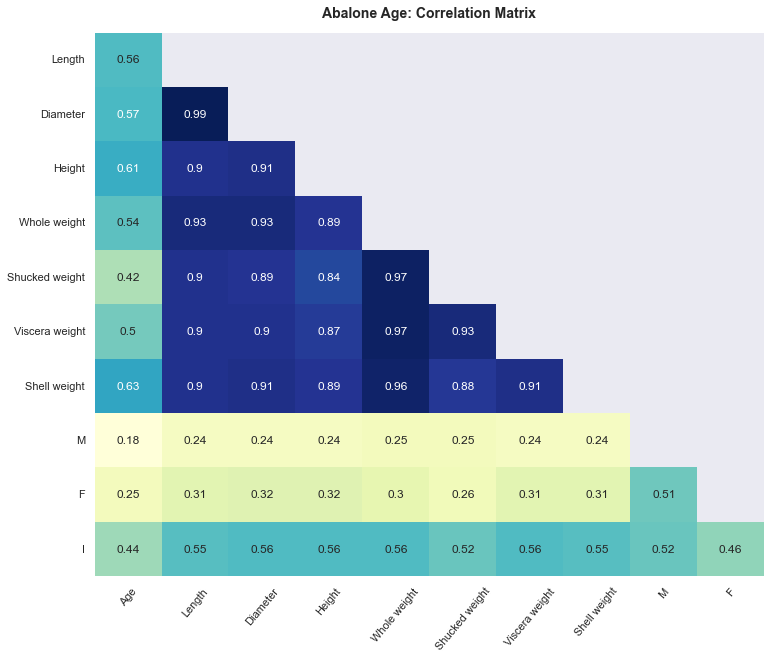

In [13]:
sns.set(rc={'figure.figsize':(12,10)})

# Visually display the matrix from above
# use the yellow-green-blue color map so that high correlations are more easily identifiable
h = sns.heatmap(abalone_corr_tri2, annot=True, cmap="YlGnBu", cbar=False)

# Add plot title 
h.set_title('Abalone Age: Correlation Matrix', size=14, weight='bold', pad=15)

# rotate tick marks so they are easier to read
plt.xticks(rotation=50)

# Display plot
plt.show()

There is quite a lot of multicollinearity within this data set. This is likely because "whole weight" for example, is nearly the same as adding the shucked weight, viscera weight, and the shell weight. Even the other 3 weights are (understandably) fairly correlated with each other. Likewise, length, diameter, and height are all very highly correlated. Because of this, I decided to keep one of the measurement variables (height, since it is more correlated with age than length or diameter). I then kept the individual weights (as opposed to whole weight), and dropped male and female (since those had a very low correlation with age).

In [15]:
# features to keep
abalone_final = abalone_new.drop(['Diameter', 'Length', 'Whole weight', 'M', 'F'], axis=1)
# View refined data set
abalone_final.head()

,Age,Height,Shucked weight,Viscera weight,Shell weight,I
0,16.5,0.095,0.2245,0.1010,0.150,0
1,8.5,0.090,0.0995,0.0485,0.070,0
2,10.5,0.135,0.2565,0.1415,0.210,0
3,11.5,0.125,0.2155,0.1140,0.155,0
4,8.5,0.080,0.0895,0.0395,0.055,1


Finally, we can prepare the data for our model. After splitting into training and testing data, we will standardize our values.

In [17]:
# Import necessary modules
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Predictors
X = abalone_final.drop('Age', axis=1)
# Outcome
y = abalone_final['Age']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=33)

#Standardize
sc= StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

**3.	Create a decision tree model tuned to the best of your abilities. Explain how you tuned it.**

Create a decision tree model (no tuning)

In [18]:
# Set up the classifier for the decision tree regressor
tree_model = DecisionTreeRegressor(random_state=33)

# Create our model by fitting the classifier to our data
tree_model = tree_model.fit(X_train, y_train)
# Find my predicted values
y_pred = tree_model.predict(X_test)

# Calculate the mean squared error
mse_tree = MSE(y_test, y_pred)
# Calculate the root mean squared error
rmse_tree = mse_tree**(1/2)
print(f' Original decision tree score: {rmse_tree}')

 Original decision tree score: 3.0313853474279115


The original RMSE for this model is already fairly low. However, we will tune the model to see if we can improve even further. 

In [19]:
# Import to search for best parameters
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters that we will test on our decision tree
param_dict = {"max_depth": [None, range(1,25)],
              #"min_samples_split":range(2,4),
              "min_samples_leaf": range(1,11),
              #"min_weight_fraction_leaf":np.arange(0,1,0.1),
              "max_features": [None, range(1,10)],
              "random_state":[33],
              "max_leaf_nodes":[None, range(1,10)],
              "min_impurity_decrease":[0.0,0.1]}
            
# Instantiate the classifier
trees = DecisionTreeRegressor()

In [20]:
# Run the decision tree model through the search, using the specified parameters and 10 crossfold validation
random = RandomizedSearchCV(trees, 
                            n_iter = 20,
                            param_distributions = param_dict, 
                            cv=10,
                            scoring = 'neg_root_mean_squared_error',
                            refit='neg_root_mean_squared_error',
                            n_jobs = -1,
                            random_state=33)

# Fit the search to our training data
random.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(random.best_params_))
print("Best decision tree score is {}".format(random.best_score_))

Tuned Decision Tree Parameters: {'random_state': 33, 'min_samples_leaf': 9, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': None}
Best decision tree score is -2.4365585492504236


I experimented with several iterations of parameter tuning for the decision tree. This involved testing several different parameters with various ranges and seeing what produced the best results. I noticed that my model sometimes got worse if I added too many parameters, which is why I ended up commenting out "min_samples_split" and "min_weight_fraction_leaf." I also noticed that most parameters were best at the default value, such as min_impurity_decrease, max_leaf_nodes, max_features, and max_depth. 

The lowest RMSE I attained was approximately 2.44, which was about 0.59 lower than the original model. The best parameters for that model are printed above.

**4.	Create a random forest model tuned to the best of your abilities. Explain how you tuned it.**

Create the random forest model without any parameter tuning

In [21]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Set up the model
rf = RandomForestRegressor(n_estimators=10,
                           random_state=33)
            
# Fit the model to our training data    
rf.fit(X_train, y_train) 
# Find predicted values
y_pred_rf = rf.predict(X_test)

# Calculate the mean squared error
mse_rf = MSE(y_test, y_pred_rf)
# Calculate the root mean squared error
rmse_rf = mse_rf**(1/2)
print(f'Original random forest score: {rmse_rf}')

Original random forest score: 2.277194549434554


Already, this model is better than the basic decision tree. Considering the nature of random forest and how it utilizes a multitude of decsion trees, it is unsurprising to me that it is performing better, even without any tuning. However, we will also tune this model to increase performance even further.

In [24]:
# Setup the parameters that we will test on our random forest
param_dict = {"n_estimators": range(10,1000),
              "max_depth": [None, range(2,20)],
              "min_samples_leaf": range(1,20),
              "max_features": [None, range(1,20)],
              "max_leaf_nodes": [None, range(1,20)],
              "min_impurity_decrease": [0.0,0.1],
              "bootstrap": ["True", "False"],
              "oob_score": ["True", "False"],
              "random_state": [33],
              "warm_start": ["True", "False"],
              "max_samples": [None, range(1,20)]}
            
# Instantiate the classifier
trees = RandomForestRegressor()

In [25]:
# Run the random forest model through the search, using the specified parameters and 10 crossfold validation
random = RandomizedSearchCV(trees, 
                            n_iter = 20,
                            param_distributions = param_dict, 
                            cv=10,
                            scoring = 'neg_root_mean_squared_error',
                            refit='neg_root_mean_squared_error',
                            n_jobs = -1,
                            random_state=33)

# Fit the search to our training data
random.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(random.best_params_))
print("Best random forest score is {}".format(random.best_score_))

Tuned Random Forest Parameters: {'warm_start': 'False', 'random_state': 33, 'oob_score': 'False', 'n_estimators': 966, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.0, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': None, 'bootstrap': 'False'}
Best random forest score is -2.2066460478318604


After tuning the parameters, I was able to lower my RMSE to approximately 2.21. This is just slightly lower than the original model with default parameters (RMSE = 2.28). While creating the parameter dictionary, I started with the same ranges from the decision tree model, so that I would have a fair comparison. However, these results were not as great, so I then widened the parameter ranges for better results. Likewise, I used the same parameters within the randomizedsearchcv. 

Similar to the decision tree, I found that a lot of parameters were best left at the default values. In fact, literally every parameter, except for the number of estimators and min_samples_leaf was best at the default value. 

**5.	Create an xgboost model tuned to the best of your abilities. Explain how you tuned it.** 

Create the xgboost model without any parameter tuning

In [26]:
from xgboost import XGBRegressor

xg = XGBRegressor(random_state=33)

xg.fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)

mse_xg = MSE(y_test, y_pred_xg)
rmse_xg = mse_xg**(1/2)
print(f'Original XGBoost score: {rmse_xg}')

Original XGBoost score: 2.299942639256228


The original xgboost score is better than the decision tree model, but not quite as good as the random forest. We can tune further, however, to see how low we can get our final score to be.

In [27]:
# Setup the parameters that we will test on our XGBoost model
param_dict = { 'max_depth': range(3,10),
               'learning_rate': [0.01, 0.05, 0.1],
               'n_estimators': range(100,1000),
               'colsample_bytree': [0.3, 0.7],
               'random_state': [33]}
            
# Instantiate the classifier
trees = XGBRegressor()

In [28]:
# Run the XGBoost model through the search, using the specified parameters and 10 crossfold validation
random = RandomizedSearchCV(trees, 
                            n_iter = 20,
                            param_distributions = param_dict, 
                            cv=10,
                            scoring = 'neg_root_mean_squared_error',
                            refit='neg_root_mean_squared_error',
                            n_jobs = -1,
                            random_state=33)

# Fit the search to our training data
random.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned XGBoost Parameters: {}".format(random.best_params_))
print("Best XGBoost score is {}".format(random.best_score_))

Tuned XGBoost Parameters: {'random_state': 33, 'n_estimators': 693, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best XGBoost score is -2.201765335077259


Tuning this model took more time than the other two (computantionally and also intellectually, as I had to learn and understand the parameters). I used the following site to help me determine which parameters were possible: https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

I also referred to this article (https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663) from David Martins to help me better understand how these parameters work in context. 

The tuned model had a RMSE of about 2.20, compared to the original model, which had a score of 2.30. This was about 0.1 lower after the tuning!

**Examine feature importance, just for fun**

In [29]:
# Gives us the weights of the importance of each predictor (the feature importance)
print(tree_model.feature_importances_, X.columns)

[0.0841503  0.23524764 0.13381702 0.52410227 0.02268277] Index(['Height', 'Shucked weight', 'Viscera weight', 'Shell weight', 'I'], dtype='object')


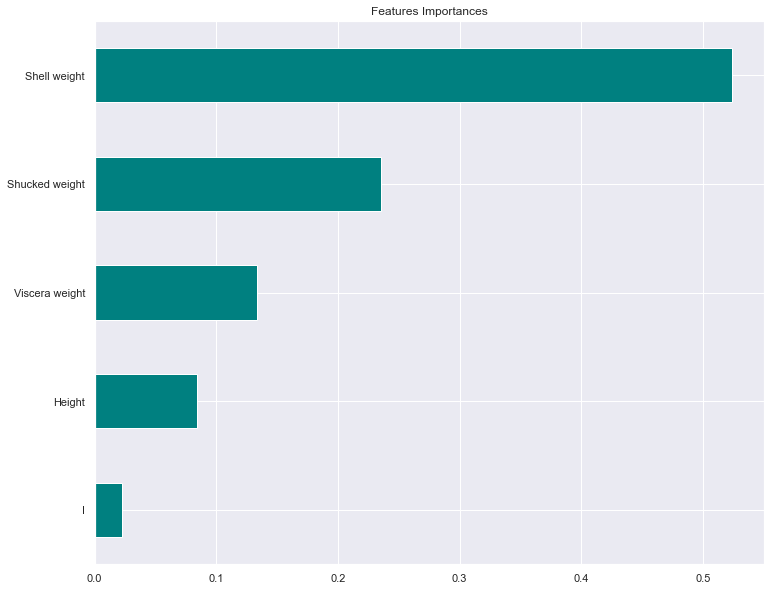

In [30]:
# Visualize which features are the most important in determining abalone age
import matplotlib.pyplot as plt

# Create pandas series
importances = pd.Series(data=tree_model.feature_importances_,
                        index= X.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='teal')
plt.title('Features Importances')
plt.show()

The feature importances above display how instrumental the shell weight is for determining the abalone age. This might be an interesting relationship to further explore in future studies.

**6.	Which model performed best? What is your performance metric? Why?** 

The XGBoost model performed better than the decision tree and the random forest model (although, only barely better than the random forest). This is because of how XGBoost models are optimized. It is an ensemble method that utilizes a mutlitude of decision trees. But unlike random forest, it uses the gradient boosting technique, meaning the decision trees are created sequentially, with each one learning from the past errors of the previous. Gradient boosting, specifcally, uses a "gradient descent algorithm" to minimize the errors (wrong predictions get higher weights - on a gradient). The XGBoost further optimizes the gradient boosting technique, which is likely why it performed the best. 

To measure performance, I used the root mean squared error (RMSE). The RMSE is a good way to help determine the total error in a regression model (which all of these models were). The lower the RMSE, the lower the error in your model. Of course, when creating models, we like to lower the error as much as possible, which is why RMSE is a good metric.

## Data Camp Certificate
**Machine Learning with Tree-Based Models**
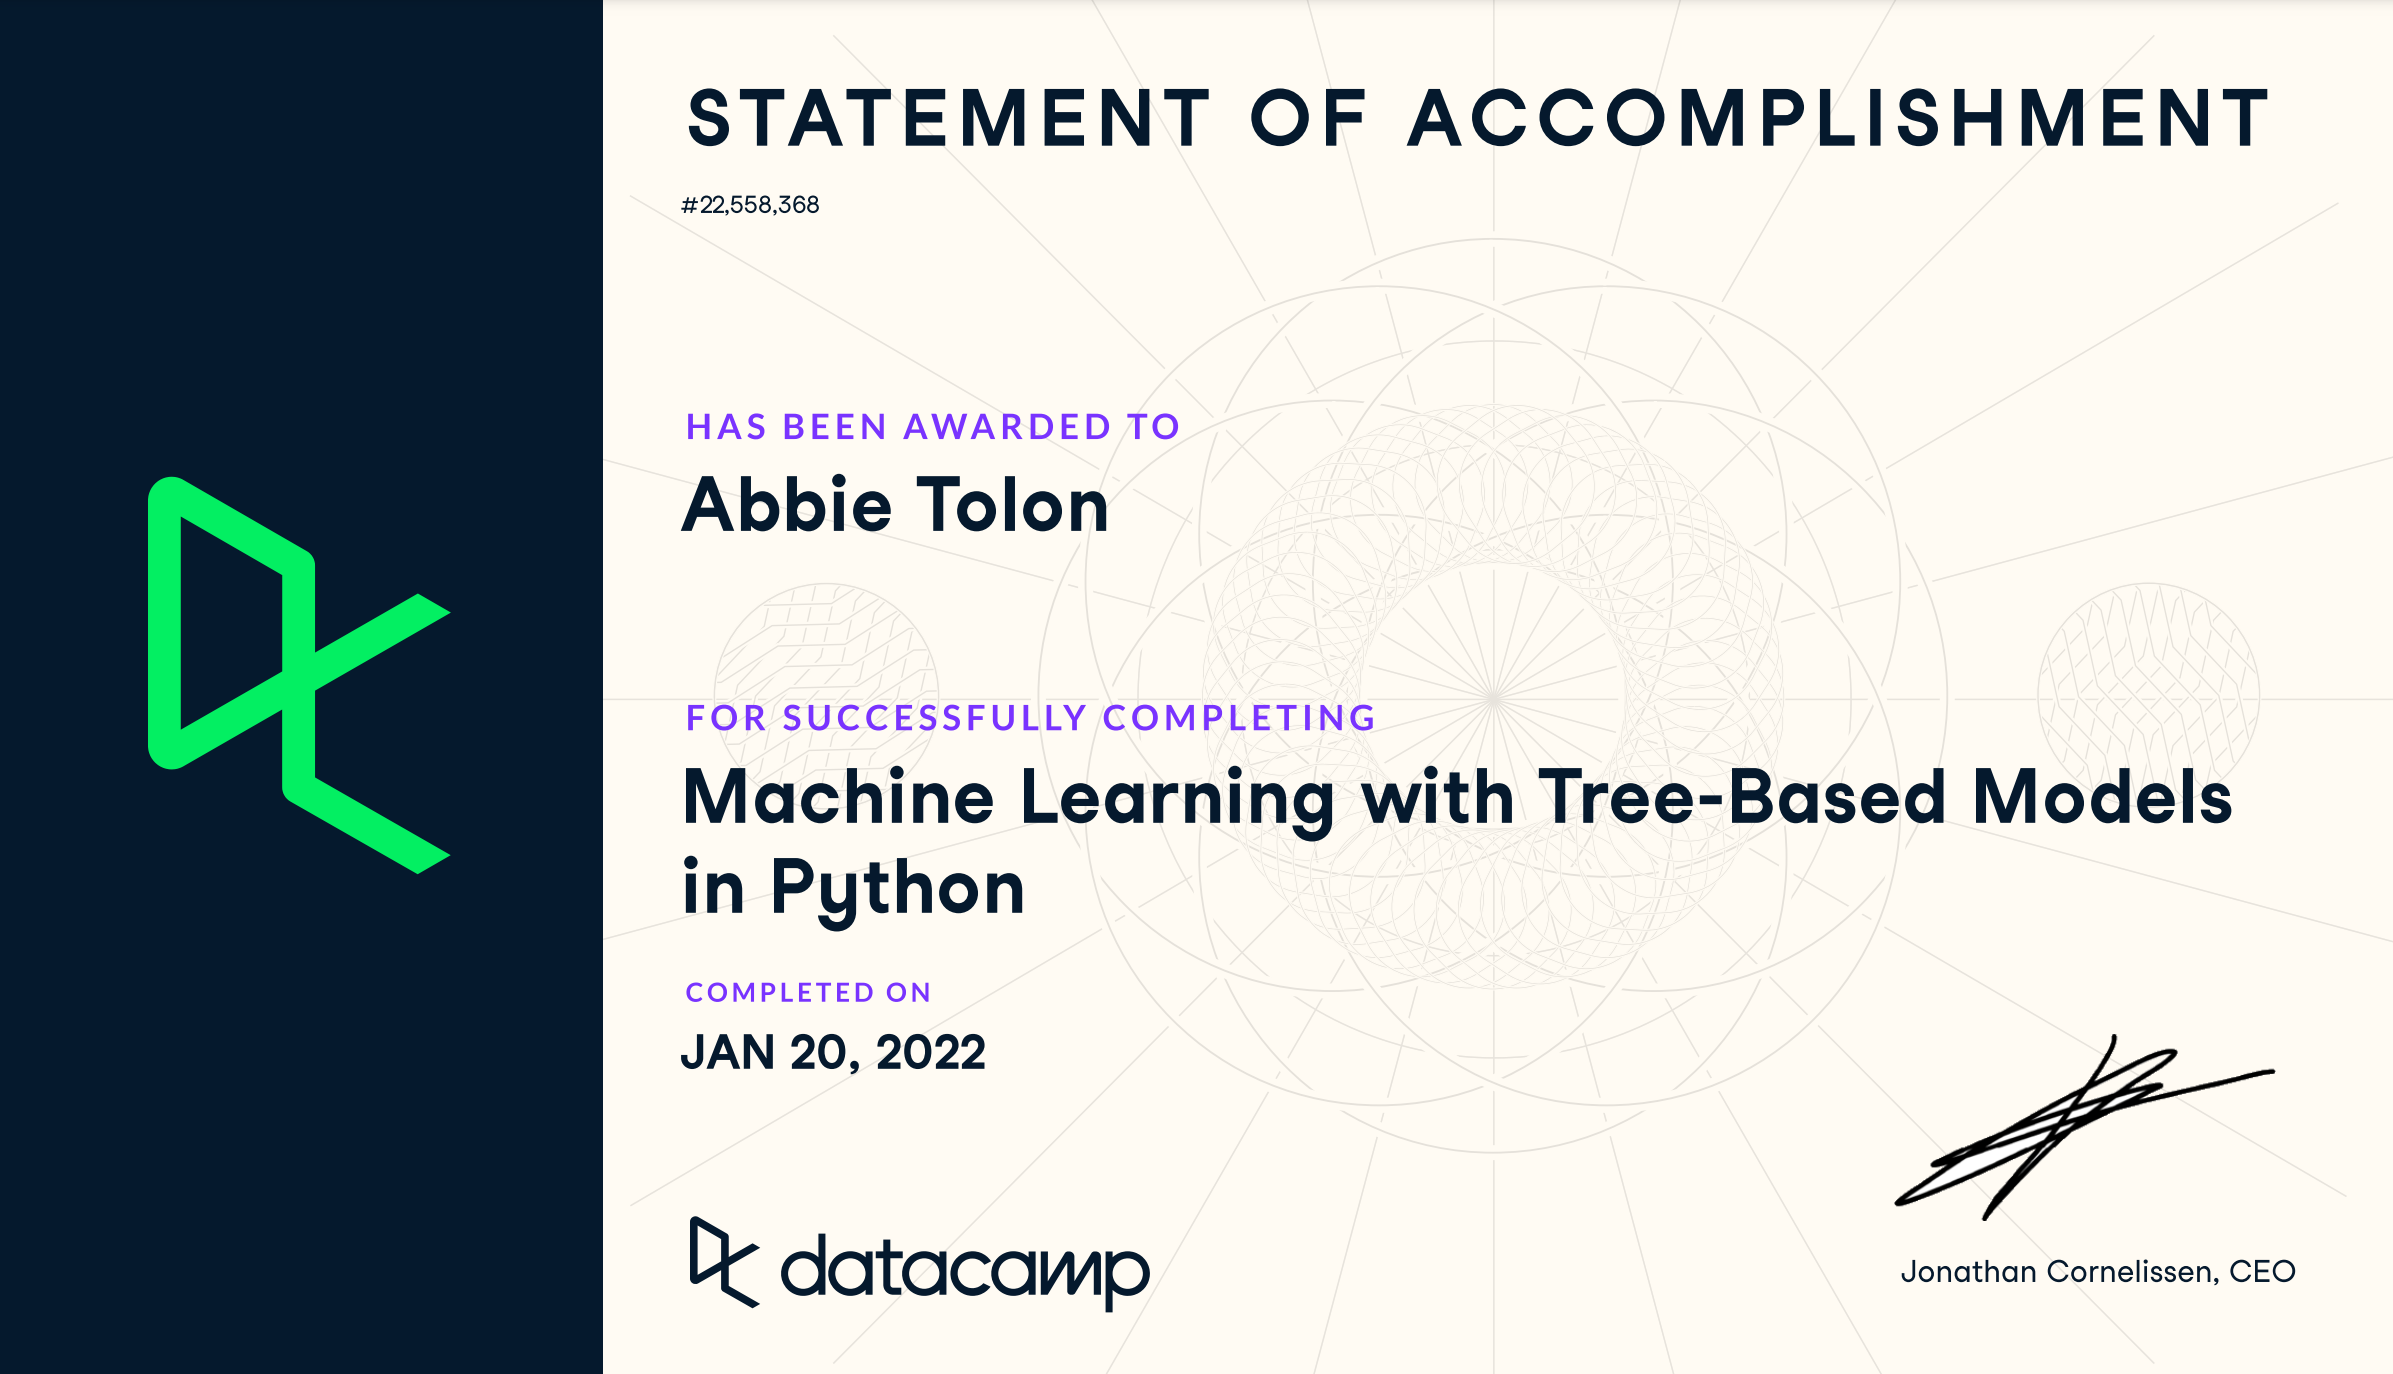